## Installing missing packages.

In [2]:
!pip install scikit-multilearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from wordcloud import WordCloud
from sqlalchemy import create_engine
import datetime as dt
from datetime import datetime
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing Data

### Creating a db file from raw data

In [ ]:
#Creating db file from csv
if not os.path.isfile('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
if os.path.isfile('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train.db'):
    start = datetime.now()
    con = sqlite3.connect('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train.db')
    pd.read_sql_query('show tables;', con)
    # num_rows = pd.read_sql_query("""SELECT count(*) FROM data;""", con)
    #Always remember to close the database
    # print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    # con.close()
    # print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("train.db does not exist.")

### Checking for duplicates

In [ ]:
if os.path.isfile('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("train.db does not exist.")

In [ ]:
df_no_dup.head()

In [ ]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

In [ ]:
df_no_dup.cnt_dup.value_counts()

In [ ]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

In [ ]:
df_no_dup.tag_count.value_counts()

### Storing data without duplicates as a CSV

In [3]:
if not os.path.isfile('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [4]:
if os.path.isfile('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("train_no_dup.db does not exist.")

Time taken to run this cell : 0:01:54.715727


## Analysis of tags

### Total Number of unique tags

In [5]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [6]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [7]:
tags = vectorizer.get_feature_names()
print(f"Sample tags: {tags[:10]}")

Sample tags: ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### Number of times a tag appears

In [8]:
freqs = tag_dtm .sum(axis=0).A1 #A1 flattens the sparse array
result = dict(zip(tags, freqs))

#### Storing the result dict as a csv

In [9]:
if not os.path.isfile('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/tag_counts_dict_dtm.csv'):
  with open('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/tag_counts_dict_dtm.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in result.items():
      writer.writerow([key, value])
tag_df = pd.read_csv('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/tag_counts_dict_dtm.csv', names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [10]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

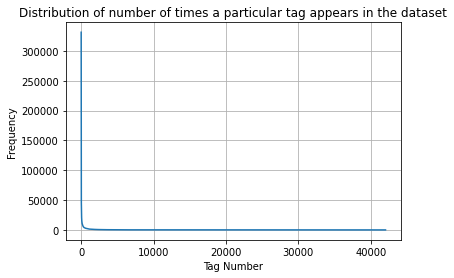

In [11]:
plt.plot(tag_counts)
plt.title('Distribution of number of times a particular tag appears in the dataset')
plt.grid()
plt.xlabel('Tag Number')
plt.ylabel('Frequency')
plt.show()

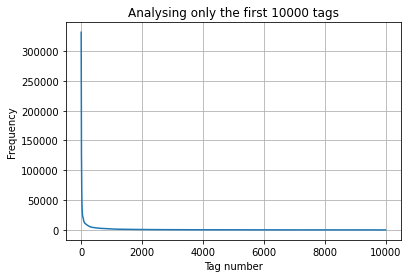

In [12]:
plt.plot(tag_counts[0:10000])
plt.title('Analysing only the first 10000 tags')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Frequency")
plt.show()
# print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

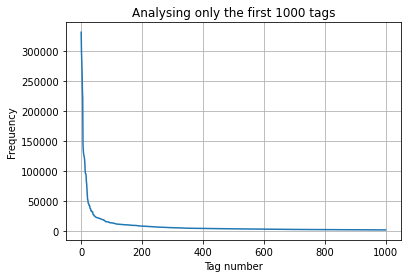

In [13]:
plt.plot(tag_counts[0:1000])
plt.title('Analysing only the first 1000 tags')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Frequency")
plt.show()
# print(len(tag_counts[0:1000:25]), tag_counts[0:1000:25])

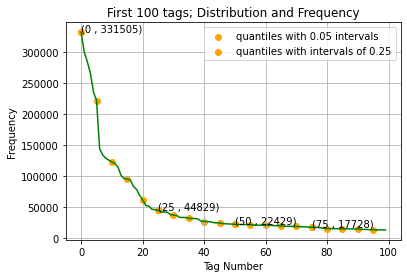

In [14]:
plt.plot(tag_counts[:100], c='g')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='orange', label='quantiles with intervals of 0.25')
for x, y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
  plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))
plt.title("First 100 tags; Distribution and Frequency")
plt.grid()
plt.xlabel('Tag Number')
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Number of Tags per Questions

In [15]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
tag_quest_count = [int(j) for i in tag_quest_count for j in i]
print(f"Number of datapoints: {len(tag_quest_count)}")

Number of datapoints: 4206314


In [16]:
print(f"Maximum Number of tags in a question: {max(tag_quest_count)}")
print(f"Minimum Number of tags in a question: {min(tag_quest_count)}")
print(f"Average Number of tags in the questions: {(sum(tag_quest_count)*1.0)/len(tag_quest_count)}")

Maximum Number of tags in a question: 5
Minimum Number of tags in a question: 1
Average Number of tags in the questions: 2.8994395092710623


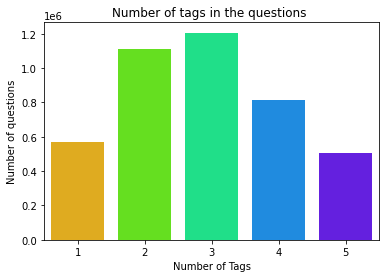

In [17]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

### Most Frequent Tags

#### Wordcloud

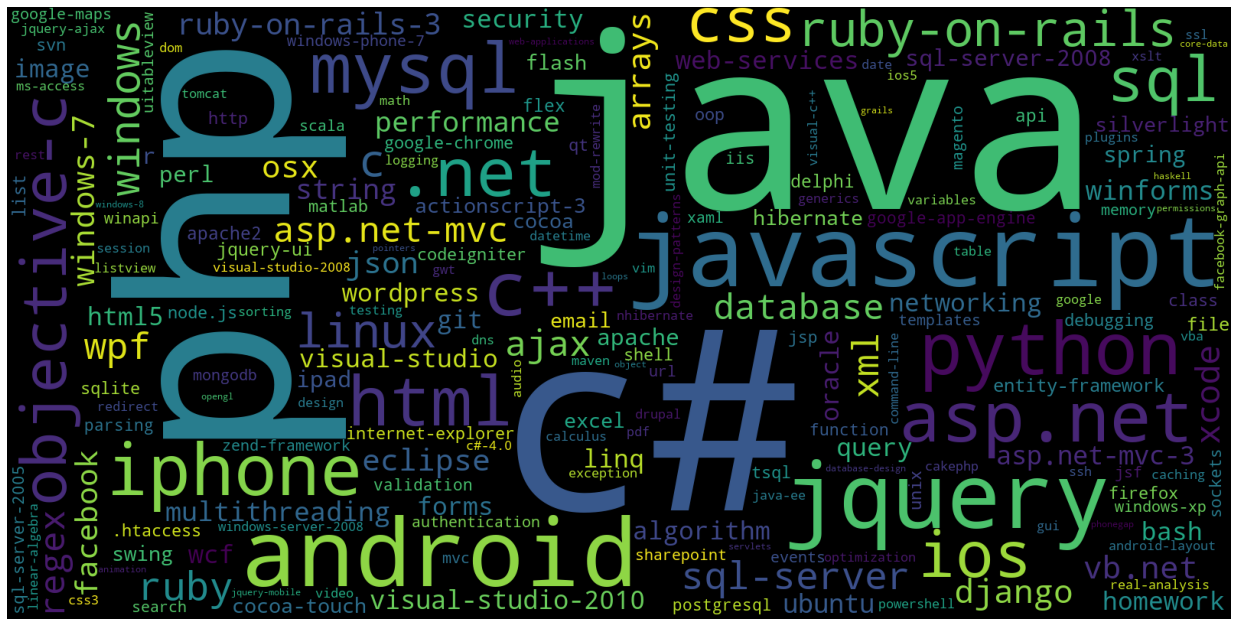

Time taken to generate wordcloud: 0:00:04.059239


In [18]:
start = datetime.now()

tup = dict(result.items())
wordcloud = WordCloud(
    background_color = 'black',
    width = 1600,
    height = 800
).generate_from_frequencies(tup)

fig = plt.figure(figsize=(20,8.5))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
fig.savefig('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/tags-wordcloud.jpg')
plt.show()

print(f"Time taken to generate wordcloud: {datetime.now() - start}")

#### Top 30 Tags

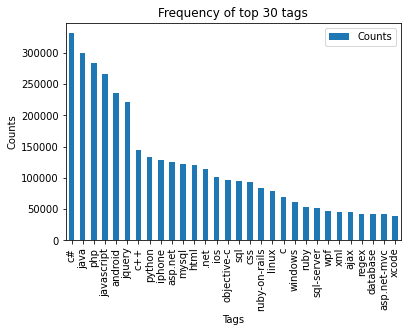

In [19]:
i = np.arange(0,30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

## Cleaning and Pre Processing of Questions

In [20]:
def striphtml(data):
  cleanre = re.compile('<.*?>')
  cleantext = re.sub(cleanre, ' ', str(data))
  return cleantext

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

In [21]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [22]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [23]:
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the database:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [24]:
def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

In [25]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/Processed.db', sql_create_table)

Tables in the database:
QuestionsProcessed


In [26]:
start = datetime.now()
read_db = '/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train_no_dup.db'
write_db = '/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/Processed.db'

In [27]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500000;")

In [28]:
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        print(tables)
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the database:
QuestionsProcessed
1
Cleared All the rows


In [29]:
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:15:37.225336


In [30]:
from tqdm import tqdm

In [31]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in tqdm(reader):
    is_code = 0
    title, question, tags = row[0], row[1], row[2]
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    title=title.encode('utf-8')
    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    #Removing all single letter and and stopwords from question except for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

100110it [02:50, 588.13it/s]

number of questions completed= 100000


200057it [05:40, 596.34it/s]

number of questions completed= 200000


300086it [08:30, 558.26it/s]

number of questions completed= 300000


400059it [11:21, 568.87it/s]

number of questions completed= 400000


499999it [14:12, 586.60it/s]

Avg. length of questions(Title+Body) before processing: 1167
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:14:12.382450


In [33]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [34]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('research start photograph low end canon digit camera found dad old sear ks standard mm len know much manual photographi feel like research learn technic aspect photographi know learn prior experiment film camera also would worth buy lens ks save money newer camera heard adapt could use connect old mount lens newer camera worth',)
----------------------------------------------------------------------------------------------------
('mysql join tabl three tabl databas first tabl one contain user inform look like second tabl contain regist user servic third tabl contain regist user servic make queri found user status second third tabl get name id user first tabl user inform result exampl would look like queri look like use inner join',)
----------------------------------------------------------------------------------------------------
('simpl audio input api mac like pull stream pcm sampl mac line built mic littl live analysi exact natur pertain question cou

In [35]:
write_db = '/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [36]:
preprocessed_data.head()

,question,tags
0,window rdp dual monitor got win pro xp pro pc ...,windows windows-8
1,research start photograph low end canon digit ...,camera-basics film old-lenses
2,mysql join tabl three tabl databas first tabl ...,mysql
3,simpl audio input api mac like pull stream pcm...,osx audio
4,access variabl hyphen name smarti got php page...,php simplexml smarty variable-names


In [37]:
print(f"number of data points in sample : {preprocessed_data.shape[0]}")
print(f"number of dimensions : {preprocessed_data.shape[1]}")

number of data points in sample : 499999
number of dimensions : 2


## Machine Learning Models

### Converting Tags to pose the problem as a Multi Label Problem

In [38]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary='true') # binary = True gives a binary vectorizer
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [39]:
multilabel_y.shape

(499999, 30679)

Taking all tags into consideration with Binary Vectoriser, will require lots of computational power. So sampling only some number of tags based on their frequency would be a better choice.

In [40]:
def tags_to_choose(n):
  t = multilabel_y.sum(axis=0).tolist()[0]
  sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
  multilabel_yn = multilabel_y[:, sorted_tags_i[:n]]
  return multilabel_yn

In [41]:
def questions_explained_fn(n):
  """
  This function returns the percent of questions covered by choosing top n tags to create the binary vectorizer.
  """
  multilabel_yn = tags_to_choose(n)
  x = multilabel_yn.sum(axis = 1)
  return (np.count_nonzero(x==0))

In [42]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

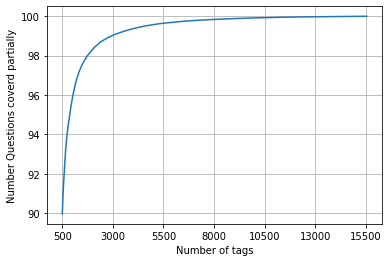

In [43]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

In [44]:
print(f"By choosing 5500 tags, we can cover {questions_explained[50]}% of the questions")

By choosing 5500 tags, we can cover 99.029% of the questions


In [45]:
multilabel_yx = tags_to_choose(5500)
print(f"Number of questions that are not covered: {questions_explained_fn(5500)} out of {total_qs}")

Number of questions that are not covered: 4855 out of 499999


In [46]:
print(f"Number of tags in sample : {multilabel_y.shape[1]}")
print(f"Number of tags taken :  {multilabel_yx.shape[1]} ({(multilabel_yx.shape[1]/multilabel_y.shape[1])*100} %)")

Number of tags in sample : 30679
Number of tags taken :  5500 (17.927572606669056 %)


### Splitting Data into Train and Test (80:20)

In [47]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [48]:
print(f"Number of data points in train data : {y_train.shape}")
print(f"Number of data points in test data : {y_test.shape}")

Number of data points in train data : (399999, 5500)
Number of data points in test data : (100000, 5500)


### Featurizing Data

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print(f"Time taken to run this cell : {datetime.now() - start}")

In [ ]:
print(f"Dimensions of train data X: {x_train_multilabel.shape} Y : {y_train.shape}")
print(f"Dimensions of test data X: {x_test_multilabel.shape} Y : {y_test.shape}")

### Multi Label K Nearest Neighbours

In [ ]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))
"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

"\nfrom skmultilearn.adapt import MLkNN\nclassifier = MLkNN(k=21)\n\n# train\nclassifier.fit(x_train_multilabel, y_train)\n\n# predict\npredictions = classifier.predict(x_test_multilabel)\nprint(accuracy_score(y_test,predictions))\nprint(metrics.f1_score(y_test, predictions, average = 'macro'))\nprint(metrics.f1_score(y_test, predictions, average = 'micro'))\nprint(metrics.hamming_loss(y_test,predictions))\n"

### Logistic Regression with OneVsRest Classifier

In [63]:
"""
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
"""

'\nclassifier = OneVsRestClassifier(SGDClassifier(loss=\'log\', alpha=0.00001, penalty=\'l1\'), n_jobs=-1)\nclassifier.fit(x_train_multilabel, y_train)\npredictions = classifier.predict(x_test_multilabel)\n\nprint("accuracy :",metrics.accuracy_score(y_test,predictions))\nprint("macro f1 score :",metrics.f1_score(y_test, predictions, average = \'macro\'))\nprint("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = \'micro\'))\nprint("hamming loss :",metrics.hamming_loss(y_test,predictions))\nprint("Precision recall report :\n",metrics.classification_report(y_test, predictions))\n'

In [64]:
from sklearn.externals import joblib

In [ ]:
pkl_file = '/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/lr_with_equal_weight.pkl'
classifier = joblib.load(pkl_file)
preditions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

### Adding more wieght to title but using only 500 tags



In [ ]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

In [ ]:
read_db = '/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/train_no_dup.db'
write_db = '/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

#### Preprocessing Questions

1. Seperate Code from Body
2. Remove special characters from Title and Description (exclusing code)

    Remove stop words (Except 'C')

    Remove HTML Tags

3. Give more weightage to title. One way to achieve this is repeating title mutliple times. 

4. Convert all characters to small characters

5. SnowballStemmer to stem the words. 

In [ ]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

In [49]:
write_db = '/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [50]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [51]:
preprocessed_data.shape

(500000, 2)

In [52]:
print(f"Number of data points in sample: {preprocessed_data.shape[0]}")
print(f"Number of dimensions: {preprocessed_data.shape[1]}")

Number of data points in sample: 500000
Number of dimensions: 2


#### Preparing tags to work with MultiLabel Problems

In [14]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

#### Selecting only 500 tags

In [53]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

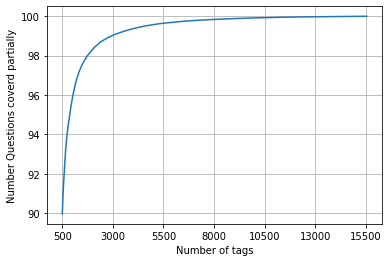

With 5500 tags, 99.029% of questions can be covered
With 500 tags, 89.967% of questions can be covered


In [54]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print(f"With 5500 tags, {questions_explained[50]}% of questions can be covered")
print(f"With 500 tags, {questions_explained[0]}% of questions can be covered")

In [55]:
multilabel_yx = tags_to_choose(500)
print(f"With 500 tags, {questions_explained_fn(500)} questions are not covered out of {total_qs}")

With 500 tags, 50165 questions are not covered out of 500000


In [57]:
train_datasize = 400000

In [58]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [59]:
print(f"Number of data points in train data : {y_train.shape}")
print(f"Number of data points in test data : {y_test.shape}")

Number of data points in train data : (400000, 500)
Number of data points in test data : (99999, 500)


#### Featurizing Data with TFIDF Vectorizer

In [60]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print(f"Time taken to run this cell : {datetime.now() - start}")

Time taken to run this cell : 0:04:44.056599


In [61]:
print(f"Dimensions of train data X: {x_train_multilabel.shape} Y : {y_train.shape}")
print(f"Dimensions of test data X: {x_test_multilabel.shape} Y: {y_test.shape}")

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (99999, 500)


In [67]:
from sklearn.externals import joblib
classifier = joblib.load('/content/drive/MyDrive/AAIC/Case Studies/Stackoverflow Tag Predictor/AAIC Data/lr_with_more_title_weight.pkl')

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)